Formal notation paired with notebook variables for reference:  
1. $f_{\theta}:\mathbb R^{k}\mapsto (0,1)$ Estimator
2. $l:\mathbb R^{k}\mapsto \{0,1\}$ Labeling function
3. $\mathcal X_{+}=\{x_{+,0},x_{+,1}...x_{+,i}|x_{+,i}\in\mathbb R^{k}, l(x_{+,i})=1 \}$ Case samples
4. $\mathcal X_{-}=\{x_{-,0},x_{-,1}...x_{-,j}|x_{-,j}\in\mathbb R^{k}, l(x_{-,j})=0 \}$ Control Samples
5. $\mathcal D=\mathcal X_{-} \cup  X_{+}$ Dataset
6. $p_{-,\theta}(\tau)$ Model output probability density function for control samples, `pdf_neg`
7. $p_{+,\theta}(\tau)$ Model output probability density function for case samples , `pdf_pos`
8. $P_{n}=P(l(x)=0)$ Probability of any sample being a control or negative prevalence, `p_neg`
9. $P_{p}=P(l(x)=1)$ Probability of any sample being a case or positive prevalence, `p_pos`
10. $TPR_{\theta}(\tau)=P(f_{\theta}(x)>\tau|l(x)=1)$ True positive rate, `tpr`
11. $FPR_{\theta}(\tau)=P(f_{\theta}(x)>\tau|l(x)=0)$ False positive rate, `fpr`
12. $PPV_{\theta}(\tau)=P(l(x)=1|f_{\theta}(x)>\tau)$ Positive predicted value, `ppv`
13. $FR_{\theta}(\tau)=P(f_{\theta}(x)>\tau)$ Firing rate, `fr`
14. $P_{a}=P(x\in A)$ Probability of sample belonging to sub-population A. `p_a`
15. $P_{b}=P(x\in B)$ Probability of sample belonging to sub-population B. `p_b`
16. $AU(ROC)_{\theta}=\int TPR_{\theta}(\tau)dFPR_{\theta}(\tau)$ AUROC, `auroc`
17. $AU(PRC)_{\theta}=\int PPV_{\theta}(\tau)dTPR_{\theta}(\tau)$ AUPRC, `auprc`


Other important formulations tha can be derived from [1-16]:  
18. $TPR(\tau)=\int_{\tau}^{1}p_{+,\theta}(\tau)d\tau$  
19. $dTPR(\tau)=-p_{+,\theta}(\tau)d\tau$ 

Similarty to [17-18]:  
20. $FPR(\tau)=\int_{\tau}^{1}p_{-,\theta}(\tau)d\tau$  
21. $dFPR(\tau)=-p_{-,\theta}(\tau)d\tau$ 

Claims from the paper:  
22. $AU(ROC)_{\theta}=1-\mathbb E[p_{+,\theta}(\tau)]\mathbb E[FPR_{\theta}(\tau)]$ `auroc_est`  
23. $AU(PRC)_{\theta}=1-P_{n}\mathbb E[p_{+,\theta}(\tau)\frac{FPR_{\theta}(\tau)}{FR_{\theta}(\tau)}]$ `auprc_est`

Please note that ${FR_{\theta}(\tau)}$ may be marginalized through [10-11-13]:    
24. $FR_{\theta}(\tau)=TPR_{\theta}(\tau)P_{p} + FPR_{\theta}(\tau)P_{n}$

In [1]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import pandas as pd

from dataclasses import dataclass, replace
from typing import Tuple, Any

import jax
import jax.numpy as jnp
import jax.random as rng
from jax.scipy.integrate import trapezoid # equivalent to numpy.trapz
from tensorflow_probability.substrates.jax.distributions import Mixture, Categorical, Beta, Distribution

from tqdm import tqdm
from itertools import product


In [80]:
@dataclass
class Model:
    """
    A Model is defined by two distributions defining respectively the control, via pdf_neg, and case, via pdf_pos, space.
    Model accepts any possible set of two distributions defined over a (0,1) domain.
    """
    pdf_neg: Distribution
    pdf_pos: Distribution

    @classmethod
    def from_beta_distribution_parameters(cls,alpha_pos:float,beta_pos:float,alpha_neg:float,beta_neg:float)->"Model":
        """Instantiate a Model from two beta distributions parametrized by the input signature.

        Args:
            alpha_pos (float): Alpha parameter of the beta cases distribution. 
            beta_pos (float): Beta parameter of the beta cases distribution.
            alpha_neg (float): Alpha parameter of the beta controls distribution.
            beta_neg (float): Beta parameter of the beta controls distribution.

        Returns:
            Model: Parametrized Model
        """
        pdf_pos=Beta(alpha_pos,beta_pos)
        pdf_neg=Beta(alpha_neg,beta_neg)
        return cls(pdf_neg=pdf_neg,pdf_pos=pdf_pos)
    
    @classmethod
    def from_beta_distribution_mean_and_variance(cls,mean_pos:float,var_pos:float,mean_neg:float,var_neg:float):
        def from_mean_and_var_to_alpha_and_beta(mean:float,var:float):
            assert var < mean*(1-mean), "Variance var must be strictly lower than mean*(1-mean)"
            nu=((mean*(1-mean))/var)-1

            alpha=mean*nu
            beta=(1-mean)*nu
            return alpha, beta
        
        return cls.from_beta_distribution_parameters(
            *from_mean_and_var_to_alpha_and_beta(mean_pos,var_pos),
            *from_mean_and_var_to_alpha_and_beta(mean_neg,var_neg))
    
    @staticmethod
    def plot_fr_tpr_fpr_ppv(model,x,ax,scenario):
        def plot_f(ax,f,label):
            _=ax.plot(x,f(),label=label)
            _=ax.set_xticks(np.arange(0,1.1,.1))
            _=ax.set_yticks(np.arange(0,1.1,.1))
            _=ax.grid(alpha=.3)
            _=ax.set_xlabel("Tau [AU]")

    
        fr_=lambda: model.fr(x,scenario)
        tpr_=lambda: model.tpr(x)
        fpr_=lambda: model.fpr(x)
        ppv_=lambda: model.ppv(x,scenario)

        for f,title in zip([fr_,tpr_,fpr_,ppv_],["FR","TPR","FPR","PPV"]):
            plot_f(ax,f,title)
            _=ax.set_ylabel(f"[AU]")
        _=ax.legend()

    @staticmethod
    def plot_output_probability_density(model,x,ax,scenario):
        _=ax.plot(x,model.pdf_neg.prob(x),color=cm.tab10(0),label="pdf_neg")
        _=ax.plot(x,model.pdf_pos.prob(x),color=cm.tab10(1),label="pdf_pos")

        _=ax.set_ylabel("dP/dTau [AU]")
        _=ax.set_xlabel("Tau [AU]")
        _=ax.set_xticks(np.arange(0,1.1,.1))
        _=ax.grid(alpha=.3)
        _=ax.legend()
        _=ax.set_title("Model Output Distribution")

    @staticmethod
    def plot_auroc(model,x,ax,scenario):
        _=ax.plot(model.fpr(x),model.tpr(x))
        _=ax.fill_between(model.fpr(x),np.zeros_like(x),model.tpr(x),alpha=.2,label=f"AU(ROC):{model.auroc():.2f}")

        _=ax.set_xticks(np.arange(0,1.1,.1))
        _=ax.set_yticks(np.arange(0,1.1,.1))
        _=ax.grid(alpha=.3)
        _=ax.set_xlabel("FPR")
        _=ax.set_ylabel("TPR")
        _=ax.set_title("Receiver Operating Characteristic - ROC")
        _=ax.legend()

    @staticmethod
    def plot_auprc(model,x,ax,scenario):
        _=ax.plot(model.tpr(x),model.ppv(x,scenario))
        _=ax.fill_between(model.tpr(x),np.zeros_like(x),model.ppv(x,scenario),alpha=.2,label=f"AU(PRC):{model.auprc(scenario):.2f}")

        _=ax.set_xticks(np.arange(0,1.1,.1))
        _=ax.set_yticks(np.arange(0,1.1,.1))
        _=ax.grid(alpha=.3)
        _=ax.set_xlabel("TPR")
        _=ax.set_ylabel("PPV")
        _=ax.set_title("Precision-Recall Curve - PRC")
        _=ax.legend()

    def plot(self,scenario,resolution:float=.01):
        x=np.arange(resolution,1,resolution)

        fig=plt.figure(figsize=(10,7))
        gs=GridSpec(2,3,fig)


        ax=fig.add_subplot(gs[0,:2])
        self.plot_output_probability_density(self,x,ax,scenario)


        # Plottin AU(ROC)
        ax=fig.add_subplot(gs[0,2])
        self.plot_auroc(self,x,ax,scenario)


        # Plotting AU(PRC)
        ax=fig.add_subplot(gs[1,2])
        self.plot_auprc(self,x,ax,scenario)


        # Plottig FR,TPR and FPR
        ax=fig.add_subplot(gs[1,:2])
        self.plot_fr_tpr_fpr_ppv(self,x,ax,scenario)

        fig.tight_layout()
        
    def tpr(self,tau:float)->float:
        return 1-self.pdf_pos.cdf(tau)
    
    def fpr(self,tau:float)->float:
        return 1-self.pdf_neg.cdf(tau)
    
    def fr(self,tau:float,scenario:"Scenario")->float:
        return (self.tpr(tau)*scenario.p_pos)+(self.fpr(tau)*scenario.p_neg)
    
    def ppv(self,tau:float,scenario:"Scenario",tol:float=1e-12)->float:
        return (scenario.p_pos*self.tpr(tau)+tol)/(scenario.p_pos*self.tpr(tau)+scenario.p_neg*self.fpr(tau) +tol)
    
    def auroc(self,resolution:float=.01)->float:
        x=jnp.arange(resolution,1+resolution,resolution)
        return -trapezoid(self.tpr(x),self.fpr(x))
    
    def auprc(self,scenario:"Scenario",resolution:float=.01)->float:
        x=jnp.arange(resolution,1+resolution,resolution)
        return -trapezoid(self.ppv(x,scenario),self.tpr(x))
    
    def score(self,scenario:"Scenario")->Tuple[float]:
        auroc=self.auroc()
        auprc=self.auprc(scenario)
        return auroc,auprc

    def auroc_est(self,resolution:float=.01)->float:
        x=jnp.arange(resolution,1,resolution)
        return 1-jnp.mean(self.pdf_pos.prob(x)*self.fpr(x))

    def auprc_est(self,scenario:"Scenario",resolution:float=.01)->float:
        x=jnp.arange(resolution,1,resolution)
        return 1-scenario.p_neg*jnp.mean(self.pdf_pos.prob(x)*(self.fpr(x)/self.fr(x,scenario)))

    def merge(self,other:"Model",scenario:"Scenario")->"Model":
        """Combines two models belonging to different sub-populations.

        Args:
            other (Model): Sub-population model to merge to the current one.
            probability (float): Prevalence of the subpopulation.

        Returns:
            Model: Combined Model.
        """
        pdf_pos=Mixture(
            Categorical([scenario.p_a,scenario.p_b]),
            [self.pdf_pos,other.pdf_pos]
        )

        pdf_neg=Mixture(
            Categorical([scenario.p_a,scenario.p_b]),
            [self.pdf_neg,other.pdf_neg]
        )
        return Model(pdf_neg=pdf_neg,pdf_pos=pdf_pos)


@dataclass
class Scenario:
    """
    Scenario is a support class carrying apriori information for a binary classification problem with at most two subpopulations.

    Example 1, Simulating a case prevalence of .1:

        >>> scenario=Scenario.case_prevalence(.1)
        >>> print(scenario.p_pos)

    Example 2, Simulating a subpopulation with prevalence of .3:

        >>> scenario=Scenario.subpopulation_prevalence(.1)
        >>> print(scenario.p_a)

    Example 3, Simulating a subpopulation with prevalence of .3 over a case prevalence of .4:

        >>> scenario=Scenario.subpopulation_prevalence(.1)+Scenario.case_prevalence(.4)
        >>> print(scenario.p_a)
        >>> print(scenario.p_pos)

    """
    p_neg:float 
    p_pos:float
    p_a:float
    p_b:float


    @classmethod
    def case_prevalence(cls,p_pos:float)->"Scenario":
        return cls(p_neg=1-p_pos,p_pos=p_pos,p_a=jnp.nan,p_b=jnp.nan)
    
    @classmethod
    def supopulation_prevalence(cls,p_a:float)->"Scenario":
        return cls(p_pos=jnp.nan,p_neg=jnp.nan,p_a=p_a,p_b=1-p_a)
    
    def __add__(self,other):
        return Scenario(
            p_a=jnp.where(jnp.isnan(self.p_a),other.p_a,self.p_a),
            p_b=jnp.where(jnp.isnan(self.p_b),other.p_b,self.p_b),
            p_pos=jnp.where(jnp.isnan(self.p_pos),other.p_pos,self.p_pos),
            p_neg=jnp.where(jnp.isnan(self.p_neg),other.p_neg,self.p_neg),
        )
    

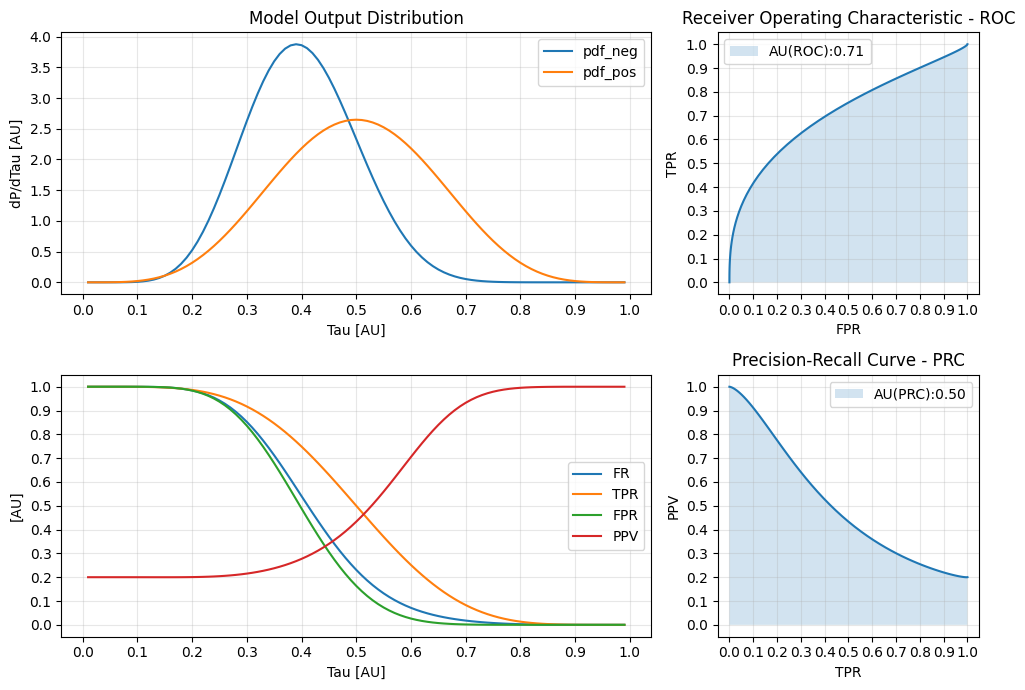

In [92]:
#Example Usage
model=Model.from_beta_distribution_mean_and_variance(.5,.02,.4,.01) # Define a model based on a beta distribution parametrized via mean and variance
model.plot(Scenario.case_prevalence(.2)) # Plotting the model performance with a case prevalence of .1

In [103]:
import ipywidgets as widgets
import plotly.graph_objects as go
import plotly.express as px

def make_scenario_tab():
    case_prevalence_slider=widgets.FloatSlider(.5,min=0,max=1,step=.01,description="Case Prevalence:", style=dict(description_width='100px'))
    popa_prevalence_slider=widgets.FloatSlider(.5,min=0,max=1,step=.01,description="A Prevalence:", style=dict(description_width='100px'))
    scenario_tab=widgets.VBox([case_prevalence_slider,popa_prevalence_slider])
    return scenario_tab,{"p_pos":case_prevalence_slider,"p_a":popa_prevalence_slider}


# POP A
def make_population_tab(scenario_handles):
    TAU=np.linspace(.01,.99,100)
    mean_pos=widgets.FloatSlider(value=.6,min=.001,max=1.0,description="Mean")
    var_pos=widgets.FloatSlider(value=.01,min=.001,max=.1,step=.001, description="Variance")
    pos=widgets.VBox([widgets.HTML("pdf_pos"),mean_pos,var_pos])

    mean_neg=widgets.FloatSlider(value=.5,min=.001,max=1.0,description="Mean")
    var_neg=widgets.FloatSlider(value=.01,min=.001,max=.1,step=.001, description="Variance")
    neg=widgets.VBox([widgets.HTML("pdf_neg"),mean_neg,var_neg])
    parameters=widgets.VBox([pos,neg])


    f_pos=go.Scatter(name="pdf_pos")
    f_neg=go.Scatter(name="pdf_neg")
    f_auroc=go.Scatter()
    f_auprc=go.Scatter()

    auroc=go.FigureWidget(go.Figure(f_auroc))
    auprc=go.FigureWidget(go.Figure(f_auprc))
    output_probability=go.FigureWidget(go.Figure(data=[f_pos,f_neg]))
    pop_tab=widgets.HBox([parameters,output_probability,auroc,auprc])

    def update_graph(change):
        model=Model.from_beta_distribution_mean_and_variance(
            mean_pos.value,
            var_pos.value,
            mean_neg.value,
            var_neg.value
        )
        scenario=Scenario.case_prevalence(scenario_handles["p_pos"].value)+Scenario.supopulation_prevalence(scenario_handles["p_a"].value)

        output_probability.data[0].x=TAU
        output_probability.data[0].y=model.pdf_pos.prob(TAU)

        output_probability.data[1].x=TAU
        output_probability.data[1].y=model.pdf_neg.prob(TAU)

        auroc.data[0].x=model.fpr(TAU)
        auroc.data[0].y=model.tpr(TAU)

        auprc.data[0].x=model.tpr(TAU)
        auprc.data[0].y=model.ppv(TAU,scenario)


    mean_pos.observe(update_graph,names="value")
    var_pos.observe(update_graph,names="value")
    mean_neg.observe(update_graph,names="value")
    var_neg.observe(update_graph,names="value")
    scenario_handles["p_a"].observe(update_graph,names="value")
    scenario_handles["p_pos"].observe(update_graph,names="value")

    return pop_tab,{"mean_pos":mean_pos,"var_pos":var_pos,"mean_neg":mean_neg,"var_neg":var_neg}


scenario_tab,scenario_handles=make_scenario_tab()
popa_tab,popa_handles=make_population_tab(scenario_handles)
popb_tab,popb_handles=make_population_tab(scenario_handles)

tabs=widgets.Tab([popa_tab,popb_tab],titles=["Population A","Population B"])
widgets.VBox([scenario_tab,tabs])

In [5]:

import plotly.graph_objects as go
import plotly.express as px

button=widgets.Button(description="Sumbit")
selection=widgets.RadioButtons(options=["TPR","FPR"])
f=go.FigureWidget(px.line(
    width=400,
    height=400))
ui=widgets.VBox([selection,button,f])

def update(b):
    if selection.value=='TPR':
        f.data[0].x=tau
        f.data[0].y=tpr

    if selection.value=='FPR':
        f.data[0].x=tau
        f.data[0].y=fpr

button.on_click(update)

display(ui)


In [6]:
import ipywidgets as widgets
from ipywidgets import interactive_output

import plotly.graph_objects as go
import plotly.express as px

elems={
    "select":widgets.RadioButtons(options=["TPR","FPR"])}

f=go.FigureWidget(px.line())
dashboard=widgets.VBox([elems["select"],widgets.Button(description="test"),f]) 

def plot_f(select):
    if select=='TPR':
        f.data[0].x=tau
        f.data[0].y=tpr
    if select=='FPR':
        f.data[0].x=tau
        f.data[0].y=fpr

out=interactive_output(plot_f,elems)
display(dashboard,out)

Output()

In [4]:
# inputs: 
# 1. prevalence of subpopulation  A  FLOAT SLIDER
# 2. prevalence of cases  FLOAT SLIDER 
# 3. beta distribution of A TWO FLOATS INPUT BOX
# 4. beta distribution of B TWO FLOATS INPUT BOX

In [7]:
import ipywidgets as wdg
from ipywidgets import interactive_output

def make_beta_parameters(title:str):
    elems={
        f"{title.lower()}_alpha_pos":wdg.FloatText(value=10,description="Alpha"),
        f"{title.lower()}_beta_pos":wdg.FloatText(value=5,description="Beta"),
        f"{title.lower()}_alpha_neg":wdg.FloatText(value=10,description="Alpha"),
        f"{title.lower()}_beta_neg":wdg.FloatText(value=5,description="Beta")
    }
    pos_float_parameters=wdg.Box([
        elems[f"{title.lower()}_alpha_pos"],
        elems[f"{title.lower()}_beta_pos"]])
    neg_float_parameters=wdg.Box([
        elems[f"{title.lower()}_alpha_neg"],
        elems[f"{title.lower()}_beta_neg"]])
    tab=wdg.Tab(children=[pos_float_parameters,neg_float_parameters],titles=["Positive","Negative"])
    beta_parameters=wdg.HBox([wdg.HTML(title),tab])
    return beta_parameters, elems

def make_scenario():
    elems={
        "p_a":wdg.FloatSlider(value=.5,min=.0,max=1.0,step=.01),
        "p_pos":wdg.FloatSlider(value=.5,min=.0,max=1.0,step=.01)
    }
    p_a=wdg.Box([wdg.HTML("Prevalence of A:"),elems["p_a"]])
    p_pos=wdg.Box([wdg.HTML("Prevalence of Cases:"),elems["p_pos"]])
    return wdg.VBox([p_a,p_pos]),elems

def make_input_dashboard():
    dash_a,elems_a=make_beta_parameters("A")
    dash_b,elems_b=make_beta_parameters("B")
    dash_s,elems_s=make_scenario()

    distributions=wdg.VBox([dash_a,dash_b])
    return wdg.HBox([dash_s,distributions]),{**elems_a,**elems_b,**elems_s}

def make_output_dashboard(): 
    elems={
        "distributions":wdg.Output(),
        "auroc_vs_auprc":wdg.Output()
    }
    return wdg.HBox([elems["distributions"],elems["auroc_vs_auprc"]]),elems

def make_dashboard():
    i,i_elems=make_input_dashboard()
    o,o_elems=make_output_dashboard()
    return wdg.VBox([i,o]),{**i_elems}


def handler(a_alpha_pos,a_beta_pos,a_alpha_neg,a_beta_neg,b_alpha_pos,b_beta_pos,b_alpha_neg,b_beta_neg,p_a,p_pos):
    a=Model.from_beta_distribution_parameters(a_alpha_pos,a_beta_pos,a_alpha_neg,a_beta_neg)
    b=Model.from_beta_distribution_parameters(b_alpha_pos,b_beta_pos,b_alpha_neg,b_beta_neg)
    scenario=Scenario.case_prevalence(p_pos).supopulation_prevalence(p_a)
    ab=a.merge(b,scenario)
    print(ab.auprc_est(scenario))


    
dashboard,elems=make_dashboard()
out=interactive_output(handler,elems)
display(dashboard,out)

Output()

In [16]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

tau=np.linspace(0,1,100)

go.Figure(go.Scatter(x=tau,y=model.tpr(tau)))

### AUROC and AUPRC 
A visual simulation of the relation between AUROC and AUPRC for different parameters and prevalences.

In [32]:
# Simulating a meshgrid of alpha and beta parameters, for both case and control samples and different prevalences
# the mesh has signature: alpha_pos, beta_pos, alpha_neg, beta_neg, p_pos

MESH_DENSITY=10

mesh=jnp.meshgrid(
    jnp.logspace(-1,1,MESH_DENSITY), # alpha_pos
    jnp.logspace(-1,1,MESH_DENSITY), # beta_pos
    jnp.logspace(-1,1,MESH_DENSITY), # alpha_neg
    jnp.logspace(-1,1,MESH_DENSITY), # beta_neg
    jnp.arange(.1,1.,.1))  # p_pos
mesh=jnp.stack(mesh)
mesh=jnp.reshape(mesh,(5,-1)).T

@jax.jit
def score_from_mesh(mesh:Any)->Tuple[float]:
    alpha_pos,beta_pos,alpha_neg,beta_neg,p_pos=mesh
    model=Model.from_beta_distribution_parameters(alpha_pos,beta_pos,alpha_neg,beta_neg)
    scenario=Scenario.case_prevalence(p_pos)
    return model.score(scenario)

# Computing AUROC-AUPRC paires at different mesh points
auroc,auprc=jnp.apply_along_axis(score_from_mesh,1,mesh)

# Storing the results in an easy to read dataframe
results=pd.DataFrame(mesh,columns=["alpha_pos","beta_pos","alpha_neg","beta_neg","p_pos"])
results["auroc"]=auroc
results["auprc"]=auprc

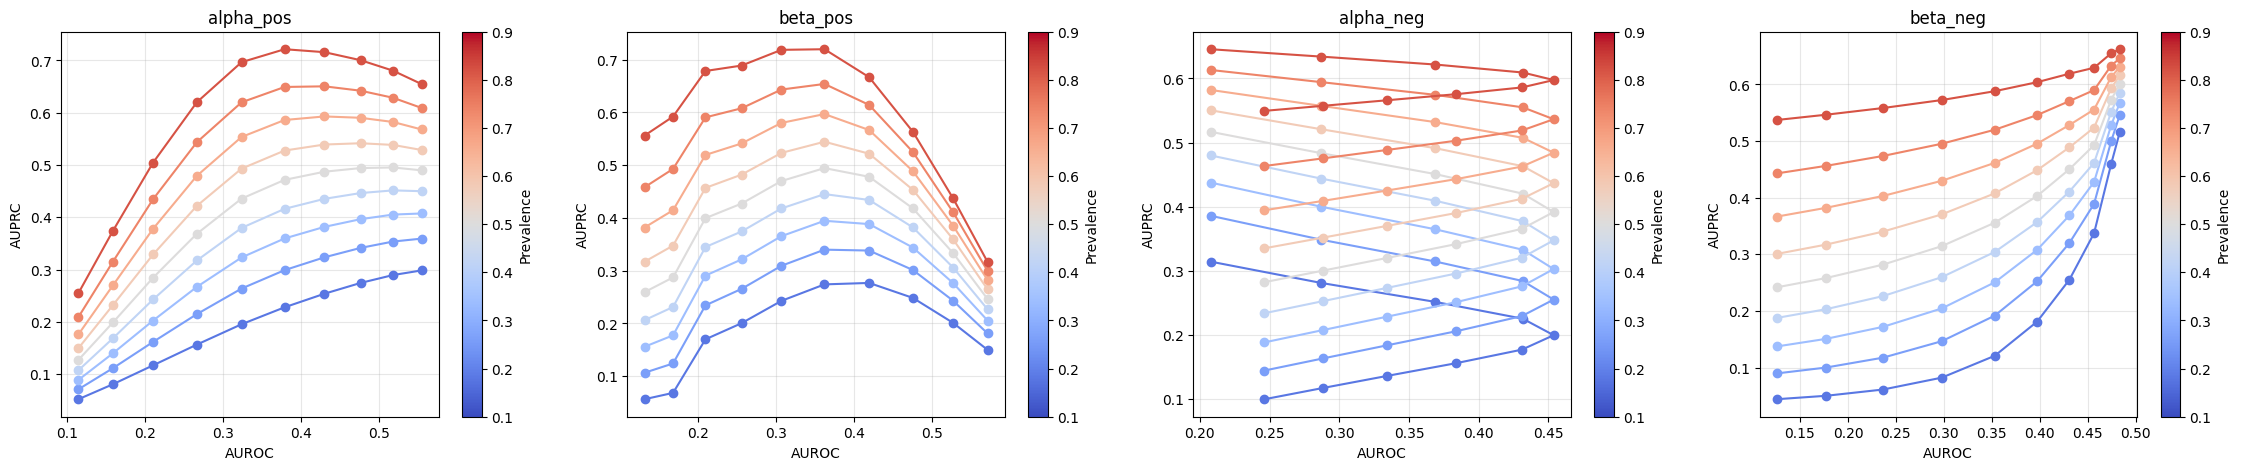

In [33]:
# Visual inspection at varying positive prevalence thresholds
fig,ax=plt.subplots(1,4,figsize=(28,5))
for cax, label in zip(ax,["alpha_pos", "beta_pos", "alpha_neg", "beta_neg"]):
    aggregated_results=results.groupby(["p_pos",label])[["auroc","auprc"]].mean()
    for p_pos in aggregated_results.index.get_level_values(0).unique():
        sp=aggregated_results.loc[p_pos].plot("auroc","auprc",ax=cax,color=cm.coolwarm(p_pos),marker='o',legend=False)
        _=cax.grid(alpha=.3)
        _=cax.set_title(label)
        _=cax.set_ylabel("AUPRC")
        _=cax.set_xlabel("AUROC")

    cbar=fig.colorbar(cm.ScalarMappable(norm=Normalize(.1,.9), cmap=cm.coolwarm), ax=cax)
    cbar.set_label("Prevalence")

### AUROC and AUPRC with subpopulations

In [140]:
# Computing AUPRC and AUROC for two subpopulations with different case prevalences.

# Experiment Settings
MESH_DENSITY=100
BATCH_SIZE=512
EPOCHS=10

# Evaluation trhesholds at different case and subpopulation prevalences
p_pos_space=jnp.arange(.1,1,.1)
p_a_space=jnp.arange(.1,1,.1)

# Sampling space for Beta parameters, 
beta_params=jnp.meshgrid(
    jnp.linspace(.1, 10,MESH_DENSITY),
    jnp.linspace(.1, 10,MESH_DENSITY),
    jnp.linspace(.1, 10,MESH_DENSITY),
    jnp.linspace(.1, 10,MESH_DENSITY),
)
beta_params=jnp.stack(beta_params)
beta_params=jnp.reshape(beta_params,(4,-1)).T

In [141]:
def evaluate(p_a,p_pos):
    scenario=Scenario.case_prevalence(p_pos) + Scenario.supopulation_prevalence(p_a)

    @jax.jit
    @jax.vmap
    def evaluate_parameters(params_a,params_b):
        model_a=Model.from_beta_distribution_parameters(*params_a)
        model_b=Model.from_beta_distribution_parameters(*params_b)
        model_ab=model_a.merge(model_b,scenario)

        auroc_a,auprc_a=model_a.score(scenario)
        auroc_ab, auprc_ab=model_ab.score(scenario)
        return {"p_a":p_a,"p_pos":p_pos,"auroc_a":auroc_a,"auprc_a":auprc_a,"auroc_ab":auroc_ab,"auprc_ab":auprc_ab}
    return evaluate_parameters


In [142]:
results=[]
for p_a,p_pos in tqdm(product(p_a_space,p_pos_space)):
    f=evaluate(p_a,p_pos)
    for epoch in range(EPOCHS): 
        params_a=rng.choice(rng.PRNGKey(epoch),beta_params,(BATCH_SIZE,))
        params_b=rng.choice(rng.PRNGKey(epoch+EPOCHS),beta_params,(BATCH_SIZE,))
        results.append(pd.DataFrame(f(params_a,params_b)))


81it [11:21,  8.41s/it]


In [143]:
metrics=pd.concat(results,axis=0)

In [154]:
metrics["ratio"]=metrics["auroc_a"]/metrics["auprc_a"]

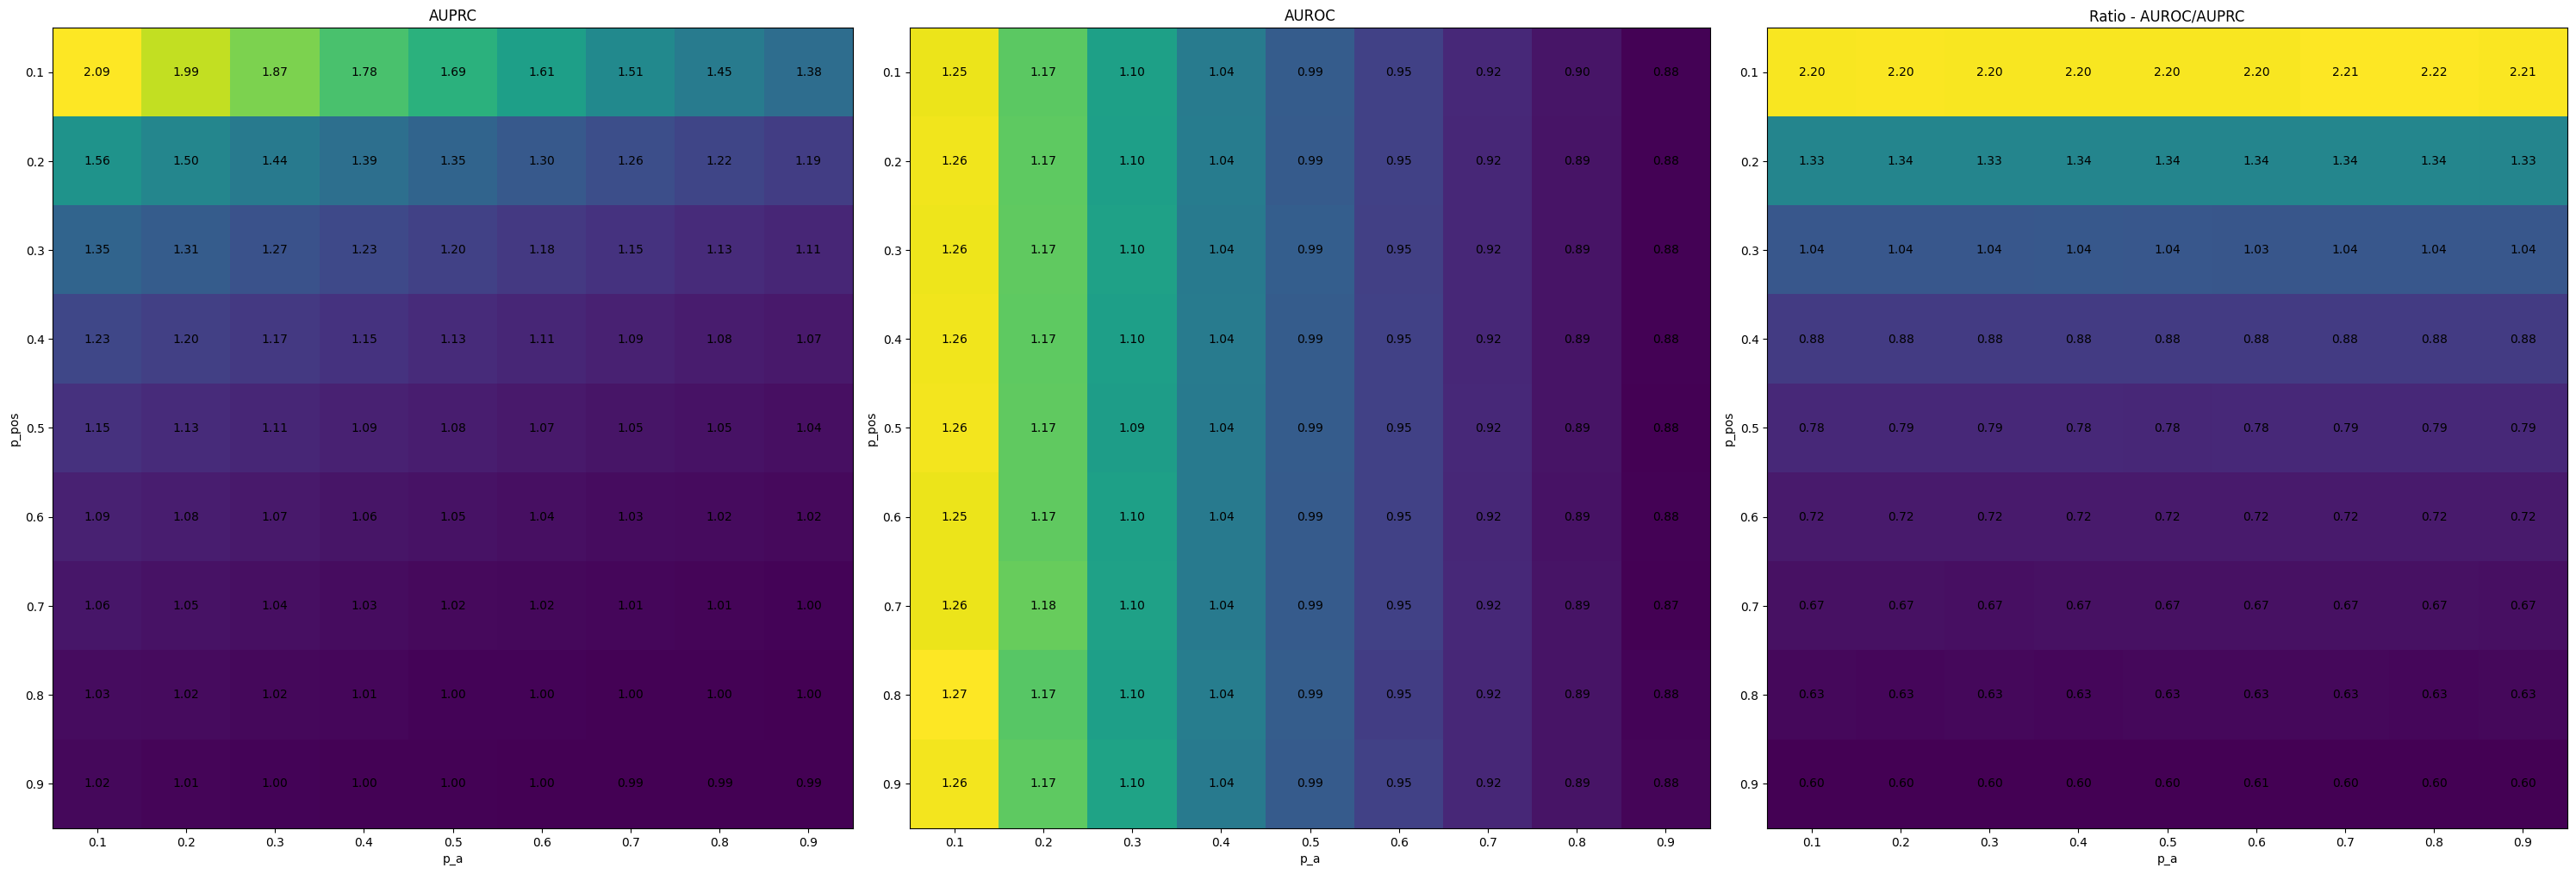

In [159]:
metrics["d_auroc"]=metrics.auroc_a/metrics.auroc_ab
metrics["d_auprc"]=metrics.auprc_a/metrics.auprc_ab
metrics["ratio"]=metrics["auroc_a"]/metrics["auprc_a"]

fig,ax=plt.subplots(1,3,figsize=(30,10))

data=metrics.dropna().sample(100000).groupby(["p_pos","p_a"]).d_auprc.mean().unstack() 
[data:=data+metrics.dropna().sample(100000).groupby(["p_pos","p_a"]).d_auprc.mean().unstack() for _ in range(100)]
data/=100

_=ax[0].imshow(data)
_=ax[0].set_xticks(range(9))
_=ax[0].set_xticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9])
_=ax[0].set_xlabel("p_a")

_=ax[0].set_yticks(range(9))
_=ax[0].set_yticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9])
_=ax[0].set_ylabel("p_pos")
_=ax[0].set_title("AUPRC")

for i,j in product(range(9),range(9)):
    _=ax[0].text(j,i,f"{data.iloc[i,j]:.2f}",ha="center",va="center")


data=metrics.dropna().sample(100000).groupby(["p_pos","p_a"]).d_auroc.mean().unstack() 
[data:=data+metrics.dropna().sample(100000).groupby(["p_pos","p_a"]).d_auroc.mean().unstack() for _ in range(100)]
data/=100

_=ax[1].imshow(data)
_=ax[1].set_xticks(range(9))
_=ax[1].set_xticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9])
_=ax[1].set_xlabel("p_a")

_=ax[1].set_yticks(range(9))
_=ax[1].set_yticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9])
_=ax[1].set_ylabel("p_pos")
_=ax[1].set_title("AUROC")

for i,j in product(range(9),range(9)):
    _=ax[1].text(j,i,f"{data.iloc[i,j]:.2f}",ha="center",va="center")


data=metrics.dropna().sample(100000).groupby(["p_pos","p_a"]).ratio.mean().unstack() 
[data:=data+metrics.dropna().sample(100000).groupby(["p_pos","p_a"]).ratio.mean().unstack() for _ in range(100)]
data/=100

_=ax[2].imshow(data)
_=ax[2].set_xticks(range(9))
_=ax[2].set_xticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9])
_=ax[2].set_xlabel("p_a")

_=ax[2].set_yticks(range(9))
_=ax[2].set_yticklabels([.1,.2,.3,.4,.5,.6,.7,.8,.9])
_=ax[2].set_ylabel("p_pos")
_=ax[2].set_title("Ratio - AUROC/AUPRC")

for i,j in product(range(9),range(9)):
    _=ax[2].text(j,i,f"{data.iloc[i,j]:.2f}",ha="center",va="center")

fig.tight_layout()

In [88]:
scenario=Scenario.from_prevalence(.1)
model_a=Model.from_beta_distribution_parameters(10,2,2,10)
model_b=Model.from_beta_distribution_parameters(2,2,1,2)
model_ab=model_a.merge(model_b,.2)

print(model_a.auroc())
print(model_b.auroc())
print(model_ab.auroc())

0.99464655
0.68006957
0.83002776


In [57]:
print(model_a.auprc(scenario))
print(model_b.auprc(scenario))
print(model_ab.auprc(scenario))

0.99345577
0.18035576
0.3689934
